# Projeto 3 Ciência dos Dados

### Lucas Muchaluat, Luiz Vitor Germanos e Matheus Ferreira

### Introdução

###### Nesse documento você encontrará uma análise sobre a relação entre o bitcoin e o ouro em uma tentativa de prever o preço do ouro (Spot) baseado no preço do bitcoin. Partimos da premissa que ambos os ativos servem como _____ e portanto teriam algum tipo de correlação. Nossa análise consiste em fazer regressões e a partir das regressões validar as relações entre os dois ativos. 

###### Import´s

In [2]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm, probplot
import statsmodels.api as sm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.style.use('fivethirtyeight')
# # plt.style.use('ggplot')

##### Obtendo os dados 

In [4]:
#lendo informação obtida no site coinmarketcap.com
cmc_2017 = pd.read_csv("coinmarketcap_06122017.csv")
#imprimindo as primeiras linhas do dataset
cmc_2017.head(5)

,Unnamed: 0,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,0,9.007640e+09,1.672352e+07,bitcoin,1512549554,2.130493e+11,2.100000e+07,Bitcoin,0.12,7.33,17.45,1.000000,12739.500000,1,BTC,1.672352e+07
1,1,1.551330e+09,9.616537e+07,ethereum,1512549553,4.352945e+10,NaN,Ethereum,-0.18,-3.93,-7.33,0.036177,452.652000,2,ETH,9.616537e+07
2,2,1.111350e+09,1.684044e+07,bitcoin-cash,1512549578,2.529585e+10,2.100000e+07,Bitcoin Cash,1.65,-5.51,-4.75,0.120050,1502.090000,3,BCH,1.684044e+07
3,3,2.936090e+09,2.779530e+09,iota,1512549571,1.475225e+10,2.779530e+09,IOTA,-2.38,83.35,255.82,0.000424,5.307460,4,MIOTA,2.779530e+09
4,4,2.315050e+08,3.873915e+10,ripple,1512549541,9.365343e+09,1.000000e+11,Ripple,0.56,-3.70,-14.79,0.000019,0.241754,5,XRP,9.999309e+10


In [5]:
#realizando os mesmos passos feitos acima para 2018
cmc_2018 = pd.read_csv("coinmarketcap_06012018.csv")
cmc_2018.head(5)

,Unnamed: 0,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,0,22081300000,16785225,bitcoin,1515230661,284909052105,2.100000e+07,Bitcoin,-0.42,5.76,26.04,1.000000,16973.800000,1,BTC,16785225
1,1,5221370000,38739144847,ripple,1515230641,119207709132,1.000000e+11,Ripple,-0.26,-9.23,24.15,0.000186,3.077190,2,XRP,99993093880
2,2,5705690000,96803840,ethereum,1515230649,100115499075,NaN,Ethereum,0.29,-1.04,45.01,0.062517,1034.210000,3,ETH,96803840
3,3,1569900000,16896225,bitcoin-cash,1515230652,44424061657,2.100000e+07,Bitcoin Cash,0.03,7.99,2.81,0.158934,2629.230000,4,BCH,16896225
4,4,428305000,25927070538,cardano,1515230654,25916647856,4.500000e+10,Cardano,0.39,-5.87,64.99,0.000060,0.999598,5,ADA,31112483745


In [6]:
#listando as colunas do dataset
list(cmc_2017)

['Unnamed: 0',
 '24h_volume_usd',
 'available_supply',
 'id',
 'last_updated',
 'market_cap_usd',
 'max_supply',
 'name',
 'percent_change_1h',
 'percent_change_24h',
 'percent_change_7d',
 'price_btc',
 'price_usd',
 'rank',
 'symbol',
 'total_supply']

In [7]:
# Selecionando as colunas 'name' e 'market_cap_usd'
market_cap_2017 = cmc_2017[['name', 'market_cap_usd']]
market_cap_2018 = cmc_2018[['name', 'market_cap_usd']]

# Contando o número de valores de cada uma delas
market_cap_2017.count()

name              1326
market_cap_usd    1031
dtype: int64

 Como existem mais "id" que "market caps" podemos concluir que existem moedas sem um share no mercado

In [9]:
# Filtrando as linhas sem um market capitalization
# market_cap = market_cap.query('market_cap_usd > 0')
market_cap_2017 = market_cap_2017[market_cap_2017["market_cap_usd"]>0]
market_cap_2018 = market_cap_2018[market_cap_2018["market_cap_usd"]>0]

# Contando o número de valores novamente
market_cap_2017.count()

name              1031
market_cap_usd    1031
dtype: int64

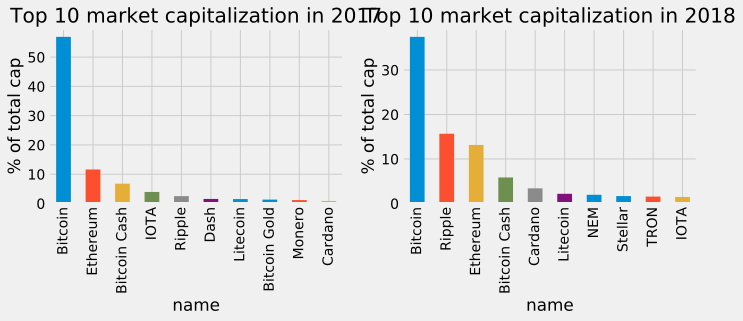

In [10]:
# Selecionando as 10 primeiras linhas e setando o index via nome da moeda
market_cap10_2017 = market_cap_2017.head(10).set_index('name')
market_cap10_2018 = market_cap_2018.head(10).set_index('name')

# Calculando porcentagem do market cap da moeda em relação ao total
market_cap10_2017 = market_cap10_2017.assign(market_cap_perc_2017 = lambda x: (x["market_cap_usd"] / market_cap_2017["market_cap_usd"].sum()) * 100)
market_cap10_2018 = market_cap10_2018.assign(market_cap_perc_2018 = lambda x: (x["market_cap_usd"] / market_cap_2018["market_cap_usd"].sum()) * 100)

# Plotando o gráfico de barras para analisar o tamanho que cada moeda tem no mercado de criptos
plt.figure(figsize=(16,3))
plt.subplot(131)
plot = market_cap10_2017.market_cap_perc_2017.plot.bar(title='Top 10 market capitalization in 2017')
plot.set_ylabel('% of total cap')

plt.subplot(132)
plot = market_cap10_2018.market_cap_perc_2018.plot.bar(title='Top 10 market capitalization in 2018')
plot.set_ylabel('% of total cap');

Se formos analisar as top 3 criptomoedas mais dominantes do mercado em ambos os anos, conseguimos perceber duas que foram recorrentes: BITCOIN E ETHEREUM.

In [11]:
# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-11-21,4465.54,4675.73,4343.98,4602.17,6120120000,80020171047
1,2018-11-20,4863.93,4951.61,4272.11,4451.87,8428290000,77401044320
2,2018-11-19,5620.78,5620.78,4842.91,4871.49,7039560000,84688539692
3,2018-11-18,5559.74,5653.61,5559.74,5623.54,4159680000,97753714643
4,2018-11-17,5578.58,5578.58,5519.56,5554.33,4303150000,96542098114


In [12]:
# get market info for ethereum from the start of 2016 to the current day
ethereum_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
ethereum_market_info = ethereum_market_info.assign(Date=pd.to_datetime(ethereum_market_info['Date']))
# when Volume is equal to '-' convert it to 0
# ethereum_market_info.loc[ethereum_market_info['Volume']=="-",'Volume']=0
# convert to int
ethereum_market_info['Volume'] = ethereum_market_info['Volume'].astype('int64')
# sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# this will remove those asterisks
ethereum_market_info.columns = ethereum_market_info.columns.str.replace("*", "")
# look at the first few rows
ethereum_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-11-21,131.14,138.89,125.76,136.70,2685930000,14127420909
1,2018-11-20,148.81,151.25,126.36,130.34,3134410000,13467303239
2,2018-11-19,177.18,177.18,147.85,149.18,2745160000,15410551811
3,2018-11-18,174.18,179.15,174.18,177.07,1810920000,18288411984
4,2018-11-17,175.36,175.85,172.87,174.00,1832800000,17968221715


In [13]:
bitcoin_market_info['Close'].describe()

count     2034.000000
mean      2280.187173
std       3443.225874
min         68.430000
25%        320.270000
50%        596.425000
75%       2576.057500
max      19497.400000
Name: Close, dtype: float64

In [14]:
ethereum_market_info['Close'].describe()

count    1203.000000
mean      214.045211
std       278.868059
min         0.434829
25%         9.965000
50%        45.300000
75%       326.770000
max      1396.420000
Name: Close, dtype: float64

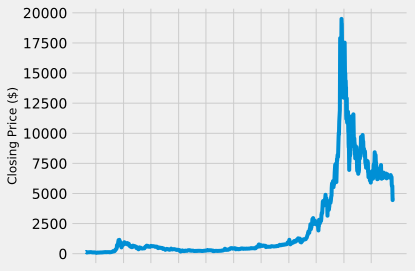

In [15]:
fig, ax1 = plt.subplots(1,1, gridspec_kw = {'height_ratios':[3]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['Close'])
fig.tight_layout()
plt.show()

In [16]:
Ouro = pd.read_excel('XAU_USD Historical Data (1) 2.xlsx')
Ouro = Ouro.assign(Date=pd.to_datetime(Ouro['Date']))
Ouro["Delta Ouro"] = Ouro["Price"] - Ouro["Open"]
Ouro.set_index('Date',inplace = True)
Ouro.head()

,Price,Open,High,Low,Change %,Delta Ouro
Date,,,,,,
2018-11-21,1225.83,1221.74,1230.12,1219.87,0.0035,4.09
2018-11-20,1221.55,1224.37,1229.17,1219.67,-0.0020,-2.82
2018-11-19,1224.05,1221.76,1225.26,1217.52,0.0012,2.29
2018-11-18,1222.62,1222.49,1222.84,1221.69,0.0009,0.13
2018-11-16,1221.47,1213.02,1225.37,1212.48,0.0070,8.45
